# Clusterização Espectral
## Autor: Matheus do Ó Santos Tiburcio

In [1]:
using LinearAlgebra
using Plots
using Random
using StatsBase
using MLJBase
using VegaLite
using DataFrames

# Breves comentários

Este notebook resume um pouco da teoria e traz consigo uma implementação do algoritmo. Para um entendimento melhor da teoria por detrás do algoritmo, recomendo fortemente a leitura do relatório em PDF que escrevi disponível em (link), nele as explicações estão bem mais detalhadas e alguns resultados também são mostrados.

# O método

Clusterização é um método de aprendizagem não-supervisionado bem conhecido na área aprendizado de máquina. Tal método consiste em, dado um conjunto de pontos $X$, determinar clusters ou agrupamentos para esses pontos. Diversas técnicas de inúmeros tipos e categorias que se enquadram como clusterização existem e a clusterização espectral é mais uma dessas.

Uma de suas vantagens é a de facilidade de determinar clusters "não-lineares", isto é, agrupamentos curvados são possíveis de serem encontrados utilizando tal método. É um método bem utilizado em imagens, conseguindo separar elementos da imagem. Nesse caso, os agrupamentos são compostos de pixels que componham algum elemento da imagem.

## Especificação

De modo geral, o problema é modelado utilizando a ideia de grafos e os agrupamentos são tratados como partições deste grafo. A pergunta natural é "o que seria uma boa partição?" e, respondida essa primeira pergunta, "como encontro essa boa partição?". Antes de entrar nesses detalhes, é importante definir o que é uma partição em um grafo. Aqui a definição se prenderá a bipartições, partições de tamanho 2, restrição essa que seguirá durante as explicações em diante também. Mas com algumas mudanças na teoria, o método pode facilmente ser estendido para $k$-partições, $k>2$.

Seja $G = (V, E)$ um grafo, uma bipartição $(A, B)$ de $G$ é um par de conjuntos de vértices de $G$ de maneira que $A \cup B = V$ e $A \cap B = \emptyset$.

O interesse então é encontrar tal bipartição que corte o grafo de maneira "significativa". Se considerarmos os pesos (ou custos) das arestas deste grafo como o quão similar dois vértices são de modo que vértices similares terão uma aresta com alto peso entre si, intuitivamente um corte "significativo" seria um corte em que

1. Arestas entre vértices de conjuntos distintos tenham um baixo peso.
2. Vértices de um mesmo conjunto tenham arestas com alto peso

Note que, dessa maneira, o grafo será não-direcionado, visto que se um elemento $x$ parece $w$ com outro elemento $y$, intuitivamente $y$ também parecerá $w$ com $x$. Além disso, somente arestas positivas serão utilizadas. Abaixo haverá discussões sobre como conseguir os dois tópicos citados.

### Minimização entre conjuntos distintos

De outra maneira, no primeiro ponto uma coisa que queremos é **minimizar** é o custo das arestas entre conjuntos distintos. Utilizarei um conceito de teoria dos grafos para modelar isso chamado $cut$ entre dois conjuntos de vértices. Logo queremos $(A, B)$ bipartição de $G$ que minimize
$$cut(A, B) = \sum_{u \in A, v \in B}w(u, v)$$
Onde $w(x, y)$ é o peso da aresta entre $x$ e $y$.

Apesar de intuitiva, essa minimização pode entregar resultados não tão satisfatórios. Repare que, quanto mais arestas cruzarem os conjuntos, maior será este valor. Portanto, esta minimização pode beneficiar conjuntos pequenos e até mesmo de um vértice só que contenham poucas arestas "cruzando" o conjunto, como mostrado na figura abaixo.

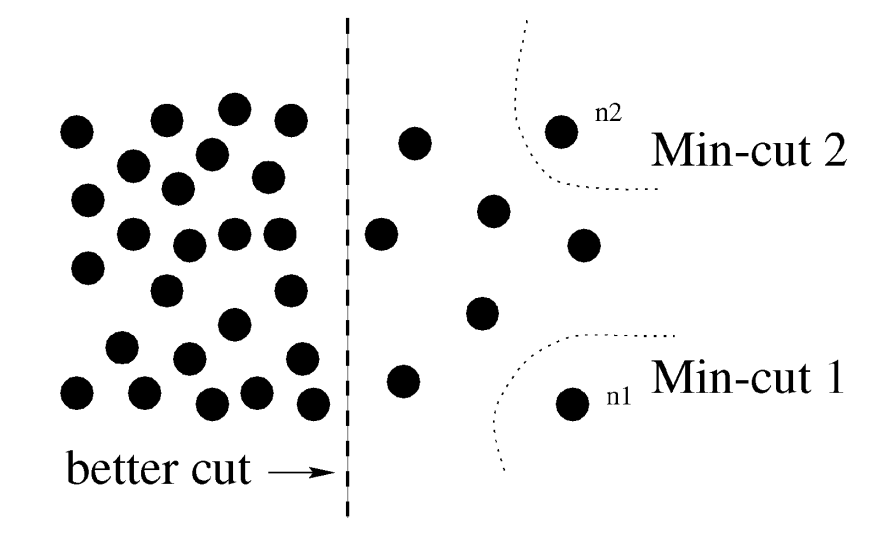

Repare como o corte mínimo isolou todo o grafo de somente um vértice a medida que, ao menos visualmente, pode-se enxergar que os dois clusters separados pela linha tracejada melhor separam o grafo. Uma solução para esse problema, e que será usada neste trabalho, é chamada de "Normalized Cut" ou "Corte Normalizado". A fim de lidar melhor com esses casos extremos, uma normalização sobre o valor de corte será feita. Para isso uma nova definição é necessária, a de "Associação".
$$assoc(A, V) = \sum_{u \in A, v \in V}w(u, v)$$
Essa medida é a soma das arestas entre os vértices de $A$ e todos os vértices de $G$. Note que arestas entre dois vértices de $A$ também são contabilizadas neste cálculo. Supondo que $A$ é o conjunto à esquerda da linha tracejada da imagem acima e analisando a figura acima, $assoc(A, V)$ agora contabiliza todas as arestas que **cruzam** a linha tracejada e todas as arestas **dentro** do conjunto $A$. Em português, gostaria que a normalização expressasse a ideia

$$\frac{\textrm{arestas que \textbf{cruzam} a linha tracejada}}{\textrm{arestas que \textbf{cruzam} a linha tracejada + arestas \textbf{dentro} do conjunto}}$$

Repare que isso já resolve nosso problema. Tome os vértices isolados da imagem, estes não possuem arestas internas e a razão seria $1$. O que essa razão diz é a **proporção** do peso das arestas que estão saindo do conjunto em comparativo com todas. Como se deseja minimizar essa razão, o preferível é reduzir o número das arestas que saem do conjunto, mas penalizando com as que estão dentro do conjunto.

Matematicamente isso pode ser expressado tomando a razão entre o $cut$, que conta as arestas que **cruzam** a linha, e $assoc$, que contabiliza tanto as que **cruzam** quanto as que ocorrem internamente em $A$, o corte normalizado entre dois conjuntos $A$ e $B$ seria então

$$Ncut(A, B) = \frac{cut(A, B)}{assoc(A, V)} + \frac{cut(B, A)}{assoc(B, V)}$$

$Ncut$ é o *normalized cut*. Repare mais uma vez que esta nova função $Ncut$ penaliza conjuntos muito pequenos, pois a medida que o conjunto diminui o número de arestas para o restante do grafo, $assoc$ diminui e a fração cresce.

### Maximização no mesmo conjunto

Além de querer minimizar as arestas entre as partições, seria interessante maximizar o valor das arestas, isto é, as similaridades entre vértices de um mesmo conjunto, como comentado no segundo ponto. Do mesmo modo que o corte foi normalizado, a associação pode ser normalizada também e é está medida que utilizaremos.

$$Nassoc(A, B) = \frac{assoc(A, A)}{assoc(A, V)} + \frac{assoc(B, B)}{assoc(B, V)}$$

O fato interessante, e que faz sentido, é que minimizando um, se maximiza o outro! Para verificar isso melhor, uma reescrita de $Ncut$ é necessária.

$$Ncut(A, B) = \frac{1}{assoc(A, V)}cut(A, B) + \frac{1}{assoc(B, V)}cut(B, A)$$
$$Ncut(A, B) = \frac{1}{assoc(A, V)}(assoc(A, V) - assoc(A, A)) + \frac{1}{assoc(B, V)}(assoc(B, V) - assoc(B, B))$$
$$Ncut(A, B) = 2 - \left(\frac{assoc(A, A)}{assoc(A, V)} + \frac{assoc(B, B)}{assoc(B, V)}\right)$$
$$Ncut(A, B) = 2 - Nassoc(A, B)$$

Note que $assoc(A, V) - assoc(A, A)$ computa a soma dos custos das arestas de $A$ para todos os vértices de $G$ e em seguida remove o custo de todas as arestas entre vértices dentro do conjunto $A$, computa exatamente a soma das arestas internas de $A$! Como $(A, B)$ é uma bipartição de $G$, o que sobra são arestas entre vértices de $A$ e $B$, que é exatamente $cut(A, B)$. A análise para $B$ é análoga. Em português, o que $Nassoc$ quer representar é

$$\frac{\textrm{arestas \textbf{dentro} do conjunto}}{\textrm{arestas que \textbf{cruzam} a linha tracejada + arestas \textbf{dentro} do conjunto}}$$

Exatamente a proporção do peso das arestas que estão internamente no conjunto. Outro modo de ver isso é que essa razão é exatamente $1 -$ a razão anterior que se gostaria de minimizar.

$$\frac{\textrm{arestas \textbf{dentro} do conjunto}}{\textrm{arestas que \textbf{cruzam} a linha tracejada + arestas \textbf{dentro} do conjunto}} = 1 - \frac{\textrm{arestas que \textbf{cruzam} a linha tracejada}}{\textrm{arestas que \textbf{cruzam} a linha tracejada + arestas \textbf{dentro} do conjunto}}$$

Assim, sem matemática, fica mais fácil ver que maximizar $Nassoc$ realmente minimiza o $Ncut$, basta trocar as razões de lado nessa igualdade! Matematicamente, para minimizar $Ncut$ é preciso maximizar $Nassoc(A, B)$, e isso é exatamente o efeito que se gostaria. Discutido isso, minimizar o $Ncut$ ou maximizar o $Nassoc$ é essencialmente a mesma coisa, então escolherei minimizar o $Ncut$. O algoritmo de clusterização espectral então tentará encontrar uma bipartição $(A, B)$ que minimize o $Ncut$. Infelizmente encontrar a bipartição ótima é um problema NP-Completo, mas manipulando a equação do $Ncut$ e relaxando o problema, uma solução aproximada pode ser obtida.

## Transformando o NCut em operações no nível de matrizes e vetores

A definição de $Ncut$ ainda pode ser mais trabalhada, a princípio a forma como está definido não indica como otimizar tal função. Para facilitar isso, tentarei descrever essa definição em termos de matrizes e vetores. Isso nos levará a um problema de minimização conhecido.

Para isso, definirei duas matrizes: $W$ matriz de pesos do grafo, cuja entrada $w_{ij}$ representa o peso da aresta entre o vértice $i$ e $j$. Como discutido anteriormente, o grafo é não-direcionado e, portanto, $W$ é simétrica, isto é, $w_{ij} = w_{ji}$ para todo par $i$, $j$; $D$ matriz de graus de cada vértice, $D$ é uma matriz diagonal cuja entrada $d_{ii}$ indica o grau do vértice $i$ definido por

$$d_{ii} = \sum_{j \in V}w_{ij}$$

Note que $assoc(A, V)$ é exatamente $\sum_{i \in A}d_{ii}$, para $B$ é análogo. Denotarei $assoc(A, V)$ e $assoc(B, V)$ como $vol(A)$ e $vol(B)$, respectivamente.

Como visto, o $Ncut$ é definido por

$$Ncut(A, B) = \frac{cut(A, B)}{vol(A)} + \frac{cut(B, A)}{vol(B)} = \frac{cut(A, B)(vol(A) + vol(B))}{vol(A)vol(B)}$$

Seja $f$ uma função indicadora cuja definição é

#### $f = \begin{equation}
    \begin{cases}
        \sqrt{\frac{vol(B)}{vol(A)}} \textrm{, se o vértice $i$ pertencer a $A$} \\
        -\sqrt{\frac{vol(A)}{vol(B)}} \textrm{, se o vértice $i$ pertencer a $B$}
    \end{cases}\end{equation}$

Se tem agora uma função que diz em que cluster cada vértice está. Um ponto interessante de dizer é que quaisquer dois valores distintos poderiam ter sido escolhidos ali, estes serão utilizados, pois simplificam as contas que se seguirão.

Esse problema é NP-Completo, visto que há $2^{n}$ combinações possíveis com esses dois valores! Mas uma solução aproximada pode ser obtida se o valor de $f$ for relaxado para qualquer vetor real.

Para uso futuro calculo $f^{T}Df$ e $f^{T}(D - W)f$

##### $f^{T}Df = \sum d_{ii}f_{i}^2 = \sum_{i \in A}d_{ii}f_{i}^{2} + \sum_{j \in B}d_{jj}f_{j}^{2} = \sum_{i \in A}d_{ii}\left(\sqrt{\frac{vol(B)}{vol(A)}}\right)^{2} + \sum_{j \in B}d_{jj}\left(-\sqrt{\frac{vol(A)}{vol(B)}}\right)^{2}$
##### $f^{T}Df = \sum_{i \in A}vol(A)\frac{vol(B)}{vol(A)} + \sum_{j \in B}vol(B)\frac{vol(A)}{vol(B)} = vol(B) + vol(A)$
<br/>

##### $f^{T}(D - W)f = \sum w_{ij}(f_{i} - f_{j})^{2} = cut(A, B)\left(\sqrt{\frac{vol(B)}{vol(A)}} - \sqrt{\frac{vol(A)}{vol(B)}}\right)^{2} = \frac{1}{2}cut(A, B)\frac{(vol(B) + vol(A))^{2}}{vol(A)vol(B)}$

Note também que $f^{T}D\mathcal{1} = 0$, que utilizarei como restrição do problema.

##### $f^{T}D\mathcal{1} = \sum_{i \in A}d_{ii}f_{i} + \sum_{j \in B}d_{jj}f_{j} = vol(A)\sqrt{\frac{vol(B)}{vol(A)}} - vol(B)\sqrt{\frac{vol(A)}{vol(B)}} = 0$

$D - W$ é a tão famosa Laplaciana do grafo, denotarei por $L$. Substituindo na definição de $Ncut$ a minimização obtém a cara

$$Ncut(A, B) = 2\frac{f^{T}Lf}{f^{T}Df}$$

sujeito a $f^{T}D\mathcal{1} = 0$.

# Minimização

Com toda a discussão feita, é desejado $\tilde{f}$ tal que

$$\tilde{f} = arg\min_{f}\frac{f^{T}Lf}{f^{T}Df}$$
sujeito a $f^{T}D\mathcal{1} = 0$.


Essa forma ainda não esclarece bem como resolver tal problema, de algum modo $D$ no denominador complica um pouco as coisas. Por sorte, tomando $g = D^{\frac{1}{2}}f$, $D$ desaparece e a minimização se torna

$$\tilde{f} = arg\min_{g}\frac{g^{T}(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})g}{g^{T}g}$$
sujeito a $g^{T}D^{\frac{1}{2}}\mathcal{1} = 0$.


Bem melhor! Agora com um fato que não provo aqui, mas no relatório em PDF, é possível verificar que um problema de otimização da forma $\frac{x^{T}Ax}{x^{T}x}$ pode ser convertido para um da forma $x^{T}Ax$ sujeito a $x^{T}x = 1$. Fazendo essa mudança a minimização é novamente transformada

$$\tilde{f} = arg\min_{g}g^{T}(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})g$$
sujeito a $g^{T}g = 1$ e $f^{T}D\mathcal{1} = 0$.

Usando multiplicadores de lagrange, tal problema é minimizado por $g^{T}(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})g - \lambda(g^{T}g - 1)$, sujeito a $g$ diferente do vetor nulo. Repare que $\lambda(g^{T}g - 1)$ é minimizado exatamente quando $g^{T}g = 1$.

Diferenciando em função de $v$, a equação obtida é $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})g + \lambda g = 0$. A definição de autovalores e autovetores! Com isso $g$ é, portanto, autovetor de $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})$. Novamente, não provarei, mas no PDF há uma explicação bem mais detalhada, porém, por uma propriedade da matriz $L$ e consequentemente de $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})$, os pontos críticos dessa função são os autovetores da matriz $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})$, sendo o valor da função nestes pontos os autovalores associados aos autovetores. Como o interesse é em minimizar tal função, a solução será o menor autovalor de $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})$ e o argumento mínimo seu autovetor associado.... Ou quase. Será que $g^{T}D^{\frac{1}{2}}\mathcal{1} = 0$ é satisfeito? A resposta é sim! Ocorre que $D^{\frac{1}{2}}\mathcal{1}$ é autovetor de $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})$.

$D^{-\frac{1}{2}}LD^{-\frac{1}{2}}(D^{\frac{1}{2}}\mathcal{1}) = D^{-\frac{1}{2}}L\mathcal{1} = D^{-\frac{1}{2}}(D - W)\mathcal{1} = D^{-\frac{1}{2}}\mathcal{1} - D^{-\frac{1}{2}}W\mathcal{1} = D^{-\frac{1}{2}}\mathcal{1} - D^{-\frac{1}{2}}D = 0$

Logo a solução é o segundo menor autovetor, $pois D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$ é simétrica e pelo teorema espectral seus autevetores são perpendiculares entre si, isto é, seu produto interno é zero. Note que, dado que o segundo menor autovetor foi obtido, caso se deseje o próximo vetor que minimize essa função, este será exatamente o terceiro menor autovetor. Não discutirei a teoria da versão generalizada, mas a solução dela é exatamente isso, os primeiro $k$ autovetores, na verdade o primeiro é excluído pelo motivo que vimos acima, mas aparemente este é considerado em algumas implementações, não sei definir o porquê.

O método de clusterização espectral se fundamenta nesse fato, os menores autovetores melhor minimizam o $Ncut$ e podem ser utilizados como uma nova base em um espaço de dimensão reduzida. Nesta dimensão reduzida é feita uma clusterização utilizando K-means ou qualquer outro algoritmo.

# Algoritmo

Agora os passos do algoritmo podem ser bem descritos.

*Entrada*: Uma matriz de adjacências $W$, $k$ indicando número de clusters, $n$ indicando o número de autovetores a serem obtidos.

*Saída*: Labels para cada ponto clusterizados em $k$ clusters.

1. Receba uma matriz de adjacências $W$ de um dado grafo.
2. Encontre os $n$ menores autovetores de $(D^{-\frac{1}{2}}LD^{-\frac{1}{2}})f = \lambda f$.
3. Use estes autovetores como base do $\mathbb{R}^{n}$.
4. Clusterize esses pontos em $k$ clusters usando algum método de clusterização.

Abaixo algumas funções foram definidas, assim como uma para o algoritmo citado acima. O método de clusterização
utilizado foi o $k$-means.

# Implementação

Para implementar, de fato, o algoritmo, algumas pequenas coisas precisam ser discutidas. As próximas subsecções discutem elas em mais detalhes.

## Matriz de similaridades e de adjacências

A primeira é "como montar a matriz de adjacências?". Bom, há jeitos e jeitos de responder isso, pode-se fazer um $k$NN nos pontos ou utilizar algum kernel. Neste caso uso o kernel RBF, cuja definição é
### $$e^{-\frac{||x_{i} - x_{j}||^{2}}{\sigma^{2}}}$$

onde $\sigma$ é um hiperparâmetro livre da escolha do usuário e $x_{i}$ e $x_{j}$ são instâncias quaisquer do problema.

Mas note que isso é somente a matriz de similaridades e não de adjacências. A diferença é que a matriz de similaridades contém a métrica de o quão similar duas instâncias são e a de adjacências, de fato, são os pesos das arestas do grafo.

De fato, pode-se utilizá-la como uma matriz de adjacências ou fazer transformações nela antes, no meu caso fiz uma pequena trandformação. A transformação que faço é manter somente as arestas entre pontos que estejam em um certo raio um do outro. Isso acrescenta o hiperparâmetro $r$, de modo que a matriz de adjacências será definida como

### $$w_{ij} = \begin{equation}
    \begin{cases}
        e^{-\frac{||x_{i} - x_{j}||^{2}}{\sigma^{2}}}, \textrm{ se } ||x_{i} - x_{j}||^{2} < r \\
        0, \textrm{ caso contrário}
    \end{cases}
\end{equation}$$

Outras funções como montar a matriz diagonal $D$ de graus dos vértices tem uma implementação mais direta.

In [2]:
function constructGraph(X, n=0, r=5, σ=4)
    #=
    Dado um conjunto de pontos, um raio e um σ,
    computa a matriz de afinidades de um grafo
    utilizando o kernel RBF.
    Entrada:
        matriz de pontos;
        número de pontos selecionados. Se = 0,
        implica usar todos;
        raio desejado. Se estiver fora do raio, a entrada
        da matriz é zerada. Se r <= 0, este corte não é
        feito;
        σ parâmetro do RBF.
    Saída:
        matriz de afinidade do grafo.
    =#
    if n == 0
        n = size(X, 2)
    end
    G = zeros((n, n))

    #percorre a parte triangular inferior de G
    #visto que é simétrico
    for i in 1:n
        for j in i:n
            #computa a distância entre os pontos e aplica
            #o kernel RBF, filtrando pelo raio r se solicitado
            distance = norm(X[:, i] - X[:, j])^2
            if r > 0 && distance < r
                    G[i, j] = exp(-distance^2 / 2σ^2)
                    G[j, i] = G[i, j]
            elseif r <= 0
                G[i, j] = exp(-distance^2 / 2σ^2)
                G[j, i] = G[i, j]
            end
        end
    end
    
    #retorna matriz simétrica de afinidades G
    return Symmetric(G)
end

function computeDegrees(W)
    #=
    Recebe uma matriz de adjacências de um grafo e retorna
    a matriz diagonal D de graus dos vértices.
    Entrada:
        matriz W de adjacências de um grafo.
    Saída:
        matriz D diagonal de graus dos vértices do grafo.
    =#
    n = size(W, 1)
    D = Diagonal(zeros((n, n)))
    one = ones(n, 1)
    for i in 1:n
        D[i, i] = (one' * W[i, :])[1]
    end
    return D
end

computeDegrees (generic function with 1 method)

## Matrizes monstruosamente gigantes

Clusterização espectral surgiu com um objetivo de segmentar imagens, isto é, separar elementos de uma imagem. Os clusters nesse caso seriam os conjuntos de pixels que compusesse algum objeto presenta na imagem. Nesses contextos, cada pixel seria um vértice do grafo e como imagens tendem a possuir uma quantidade grande de pixels, se torna inviável métodos comuns para o encontro de autovalores e autovetores da laplacina desse grafo.

Encontrar autovetores e autovalores é resolver um sistema linear, isso possui complexidade $O(n^{3})$ com $n$ sendo o número de vértices do grafo. Para resolver isso existem várias formas, o algoritmo que implemento aqui é o algoritmo de Lanczos, que se baseia no fato de uma matriz simétrica $S$ poder ser reescrita como $S = QTQ^{T}$, onde $Q$ é ortogonal e $T$ tridiagonal. Deixarei os detalhes teóricos de lado, mas no PDF do relatório há referências que discutem isso mais a fundo.

A ideia é achar uma sequência de $\tilde{Q}$ que convirja para $Q$ a cada iteração adicionando novas colunas, isso permitirá gerar uma matriz $\tilde{T}$ que converge para $T$ conforme o número de iterações aumenta. Com $\tilde{Q}$ encontrada para um dado número de iterações, $\tilde{T}$ pode ser encontrada por $\tilde{T} = \tilde{Q^{T}}S\tilde{Q}$. Converge $\tilde{T}$ converge para $T$, seus autovalores extremos (os maiores e os menores) convergem para os de $T$ que, com a devida prova, são os mesmos de $S$. Como o desejado são os menores autovalores, esse método pode ser aplicado e, com os autovalores em mãos, os autovetores podem ser encontrados simplesmente efetuando $\tilde{Q}\Lambda$, $\Lambda$ matriz com os menores autovalores de $S$.

In [3]:
#algoritmo de Lanczos para computar de maneira rápida autovetores e valores de uma
#matriz simétrica
function lanczos(S, m)
    #=
    Algoritmo de Lanczos para matrizes simétricas.
    De modo resumido, pode-se escrever uma matriz
    simétrica como QTQ^T, onde Q é ortogonal e T
    tridiagonal. Quanto mais iterações, maior o número
    de colunas de Q e maior T. A ideia é que, conforme
    as iterações aumentam, os autovalores extremos de T
    convergem para os de A.
    Entrada:
        matriz simétrica;
        número de iterações.
    Saída:
        autovalores e autovetores de T;
        matriz ortogonal tal que A ≈ QTQ^T.
    =#

    #define número de linhas e matriz Q,
    #que será populada durante o algoritmo
    n = size(S, 1)
    Q = zeros(n, m+1)

    #define a primeira coluna de Q e a normaliza
    Q[:, 1] = randn(n, 1)
    Q[:, 1] = Q[:, 1] / norm(Q[:, 1])

    #q_ é iniciado com 0
    q_ = zeros(n, 1)
    beta = 0
    
    for j in 1:m
        w = S * Q[:, j] - beta * q_
        alpha = (Q[:, j]' * w)[1]
        w = w - alpha * Q[:, j]
        beta = norm(w)
        
        q_ = Q[:, j]
        Q[:, j+1] = w / beta
    end

    #computa T e seus autovalores e vetores,
    #retornando-os junto de Q
    T = Tridiagonal(Q' * S * Q)
    return eigen(T), Q
end

lanczos (generic function with 1 method)

## O $k$-means

Os autovetores de uma matriz simétrica, como a Laplaciana, são todos perpendiculares entre si e admitem uma base para a dimensão para o espaço coluna da matriz. Nesse contexto, os autovetores encontrados são utilizados para "projetar" o grafo e seus vértices em uma dimensão cuja base são esses autovetores da laplaciana. Nessa dimensão reduzida, um método de clusterização é aplicado. Nesse trabalho utilizei o $k$-means, mas outros podem ser usados também.

In [4]:
function kmeans(P, k, maxIt = 1000)
    #=
    Dado um conjunto de pontos, número de clusters,
    e um número máximo de iterações, separa os pontos
    em k clusters.
    Entrada:
        matriz de pontos;
        número de clusters desejados;
        número máximo de iterações.
    Saída:
        classificação dos pontos nos k clusters;
        centróide de cada um dos clusters.
    =#

    #converged checa se convergiu, dimension dimensão dos pontos
    #e points número de pontos
    converged = false
    dimension = size(P, 1)
    points = size(P, 2)

    #seleciona aleatoriamente k pontos para serem centróides
    centroids = view(P, :, sample(1:points, k, replace=false))

    #define uma matriz de labels ou classificações
    #e o quanto cada classes tem de membros
    #inicialmente todos pertencem a classe 1
    labels::Matrix{Int64} = ones(1, points)
    nLabels::Matrix{Int64} = zeros(1, points)
    nLabels[1] = size(P, 2)

    #número de iterações
    it = 1

    #só para se convergir ou o número de iterações
    #tiver excedido do máximo permitido
    while !converged && it <= maxIt
        #coleta os labels da iteração anterior
        lastLabels = copy(labels)

        #vetor de soma das coordenadas dos pontos de cada
        #cluster. Serve para computar os novos centróides
        sums = zeros(dimension, k)

        #percorre cada centróide e verifica qual dos centróides
        #os pontos estão mais próximos e atualiza as informações
        for j in 1:k
            for i in 1:size(labels, 2)
                if(norm(P[:, i] - centroids[:, j]) < norm(P[:, i] - centroids[:, labels[i]]))
                    labels[i] = j
                    nLabels[i] -= 1
                    nLabels[j] += 1
                end
            end
        end

        #calcula a soma das coordenadas de cada ponto
        #em cada cluster
        for i in 1:points
            sums[:, labels[i]] += P[:, i]
        end

        #determina os novos centróides
        for j in 1:k
            centroids[:, j] = sums[:, j] .* (1 / nLabels[j])
            if lastLabels == labels
                converged = true
            end
        end

        #incrementa o número de iterações em 1
        it += 1
        
    end
    return labels, centroids
end

kmeans (generic function with 2 methods)

## Finalmente o código final do algoritmo

Após toda a discussão, o código final do algoritmo pode ser escrito. Note que, apesar de pequeno, contém toda uma teoria matemática por detrás. Padrão esse que ocorre com outros algoritmos também.

In [5]:
#Algoritmo de clusterização espectral
function spectralClustering(W, lanczos_it=200, dim_reduction=2, clusters_num=0)
    #=
    Um método de clusterização em grafos. Recebe
    uma matriz de adjacências W de um grafo e aplica
    o método de clusterização espectral no grafo.
    Entrada:
        matriz de adjacências;
        número de iterações do algoritmo de Lanczos;
        dimensão para a redução de dimensionalidade;
        número de clusters desejado.
    Saída:
        classificações de cada ponto ou vértice;
        centróides de cada cluster.
    =#
    if clusters_num == 0
        clusters_num = dim_reduction
    end
    
    #montagem do sistema
    D = computeDegrees(W)
    D_half = sqrt(D)
    invD_half = inv(D_half)
    M = invD_half * (D - W) * invD_half

    #encontro dos dim_reduction menores autovetores
    #contando a partir do 2o menor
    (eigenval, eigenvect), Q = lanczos(M, lanczos_it)
    Y = Q * eigenvect[:, 2:(1+dim_reduction)]
    Y = D_half * Y
    
    #classifica e retorna tal classificação
    return kmeans(Y', clusters_num)
end

spectralClustering (generic function with 4 methods)

# Exemplos

Nesta seção alguns exemplos são mostrados do algoritmo em ação, note que pela "não-linearidade" dele, formatos curvados não prejudicam os resultados.

In [6]:
function plotClasses(X, classificacao, k)
    #=
    Dado um conjunto de pontos em R^2 e uma
    classificação em k clusters, plota-os juntos de
    suas classificações.
    Entrada:
        matriz de pontos;
        classificação dos pontos;
        número de clusters.
    =#
    plot(title="Pontos e suas classificações", legend=:outertopright)
    classes = []

    #inicializa cada classe como a lista vazia
    for i in 1:k
        push!(classes, [])
    end

    #pega os índices dos elementos de cada classe
    for i in 1:size(classificacao, 2)
        push!(classes[classificacao[i]], i)
    end

    #um scatter para cada classe
    for i in 1:k-1
        scatter!(X[1, classes[i]], X_transformed'[2, classes[i]], label="classe $i")
    end
    display(scatter!(X[1, classes[k]], X_transformed'[2, classes[k]], label="classe $k"))
end

plotClasses (generic function with 1 method)

## Círculos concêntricos

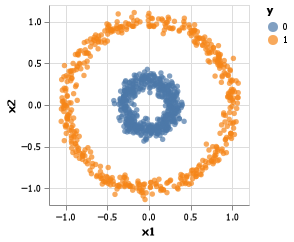

In [7]:
#gera os pontos e classes
X, y = make_circles(1000; noise=0.05, factor=0.3)
dfCircles = DataFrame(X)
dfCircles.y = y

#cria matrizes para os pontos e classes
X_ = Matrix(dfCircles)[:, 1:2]
y_ = Matrix(dfCircles)[:, 3]

#plota os pontos e suas respectivas classes
dfCircles |> @vlplot(:circle, x=:x1, y=:x2, color = :"y:n") 

In [8]:
#padroniza os dados
X_transformed = StatsBase.transform(StatsBase.fit(ZScoreTransform, X_, dims=1), X_)

#constrói a matriz de afinidade e soma um valor pequeno para
#tornar o grafo um grafo completo
G = constructGraph(X_transformed', 0, 10, 1) .+ 10^-10

1000×1000 Matrix{Float64}:
 1.0          0.149915     0.999085    …  1.49415e-10  0.332566
 0.149915     1.0          0.365271       0.028608     1.8821e-10
 0.999085     0.365271     1.0            2.13681e-8   0.127243
 3.7262e-7    0.0346054    7.00485e-6     1.0e-10      1.0e-10
 0.753092     0.652209     0.850287       7.79715e-10  0.00158374
 0.978601     0.379922     0.993142    …  7.65055e-6   0.0476312
 0.997856     0.207293     0.996206       1.0365e-10   0.243153
 0.289052     1.89421e-6   0.158469       1.0e-10      0.419167
 0.999618     0.315496     0.999987       2.90211e-9   0.165149
 1.11937e-10  0.192375     7.84632e-9     9.08558e-5   1.0e-10
 1.04682e-10  0.11781      5.40341e-9  …  0.917999     1.0e-10
 0.205401     1.17668e-10  0.0756935      1.0e-10      0.840866
 0.832432     0.585458     0.900455       3.2848e-10   0.00540755
 ⋮                                     ⋱               
 0.992906     0.213235     0.995243       1.61604e-7   0.142814
 0.000946999  0.0

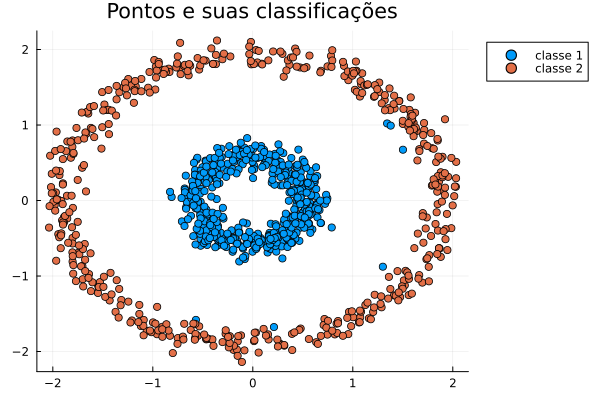

In [9]:
#aplica a clusterização espectral no grafo
classificacao, centroids = spectralClustering(G, 50, 2, 2)

#plota os resultados
plotClasses(X_transformed', classificacao, 2)

## Luas

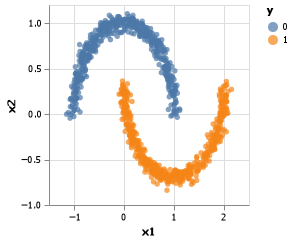

In [10]:
#gera os pontos e classes
X, y = make_moons(1000; noise=0.05)
dfMoons = DataFrame(X)
dfMoons.y = y

#cria matrizes para os pontos e classes
X_ = Matrix(dfMoons)[:, 1:2]
y_ = Matrix(dfMoons)[:, 3]

#plota os pontos e suas respectivas classes
dfMoons |> @vlplot(:circle, x=:x1, y=:x2, color = :"y:n") 

In [11]:
#padroniza os dados
X_transformed = StatsBase.transform(StatsBase.fit(ZScoreTransform, X_, dims=1), X_)

#constrói a matriz de afinidade e soma um valor pequeno para
#tornar o grafo um grafo completo
G = constructGraph(X_transformed', 0, 0.5, 0.4) .+ 10^-10

1000×1000 Matrix{Float64}:
 1.0       1.0e-10   1.0e-10   1.0e-10   …  1.0e-10   1.0e-10   1.0e-10
 1.0e-10   1.0       1.0e-10   0.922825     0.981997  0.463421  1.0e-10
 1.0e-10   1.0e-10   1.0       1.0e-10      1.0e-10   1.0e-10   1.0e-10
 1.0e-10   0.922825  1.0e-10   1.0          0.998535  1.0e-10   1.0e-10
 1.0e-10   1.0e-10   1.0e-10   0.749264     0.67497   1.0e-10   1.0e-10
 0.895425  1.0e-10   0.485197  1.0e-10   …  1.0e-10   1.0e-10   1.0e-10
 1.0e-10   1.0e-10   1.0e-10   1.0e-10      1.0e-10   1.0e-10   0.934953
 1.0e-10   1.0e-10   0.978746  1.0e-10      1.0e-10   1.0e-10   1.0e-10
 1.0e-10   1.0e-10   1.0e-10   1.0e-10      1.0e-10   1.0e-10   1.0e-10
 1.0e-10   1.0e-10   1.0e-10   0.595328     0.537172  1.0e-10   1.0e-10
 0.481788  1.0e-10   0.89955   1.0e-10   …  1.0e-10   1.0e-10   1.0e-10
 1.0e-10   0.977812  1.0e-10   0.999437     0.999689  1.0e-10   1.0e-10
 1.0e-10   0.612883  1.0e-10   0.967042     0.946399  1.0e-10   1.0e-10
 ⋮                                  

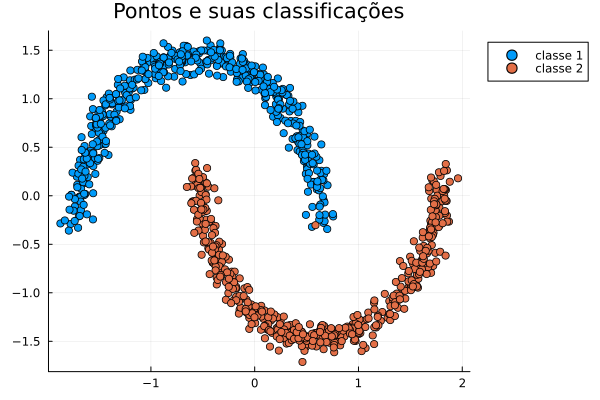

In [12]:
#aplica a clusterização espectral no grafo
classificacao, centroids = spectralClustering(G, 100, 3, 2)

#plota os resultados
plotClasses(X_transformed', classificacao, 2)